## Clustering and k-means

### Generating Samples

In [1]:
import tensorflow as tf
import numpy as np

def create_samples(n_clusters, n_samples_per_cluster, n_features, embiggen_factor, seed):
    np.random.seed(seed)
    slices = []
    centroids = []
    
    # Create samples for each cluster
    for i in range(n_clusters):
        samples = tf.random_normal((n_samples_per_cluster, n_features), mean=0.0, stddev=5.0, dtype=tf.float32, seed=seed, name='cluster_{}'.format(i))
        current_centroid = (np.random.random((1, n_features)) * embiggen_factor) - (embiggen_factor / 2)
        centroids.append(current_centroid)
        samples += current_centroid
        slices.append(samples)
        
    # Create a big 'samples' dataset
    samples = tf.concat(0, slices, name='samples')
    centroids = tf.concat(0, centroids, name='centroids')
    return centroids, samples  

In [2]:
n_features = 2
n_clusters = 3
n_samples_per_cluster = 500
seed = 700
embiggen_factor= 70

np.random.seed(seed)

centroids, samples = create_samples(n_clusters, n_samples_per_cluster, n_features, embiggen_factor, seed)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sample_values = sess.run(samples)
    centroid_values= sess.run(centroids)

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_clusters(all_samples, centroids, n_samples_per_cluster):
    plt.figure(figsize=(8, 8))
    colour = plt.cm.rainbow(np.linspace(0,1,len(centroids)))
    for i, centroid in enumerate(centroids):
        samples = all_samples[i*n_samples_per_cluster:(i+1)*n_samples_per_cluster]
        plt.scatter(samples[:,0], samples[:,1], c=colour[i])
        plt.plot(centroid[0], centroid[1], markersize=20, marker='x', color='k', mew=10)
        plt.plot(centroid[0], centroid[1], markersize=16, marker='x', color='m', mew=5)
    
    plt.show()

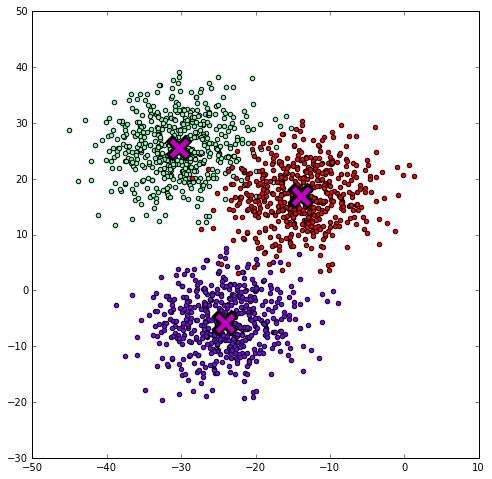

In [4]:
plot_clusters(sample_values, centroid_values, n_samples_per_cluster)

## Initialisation

In [5]:
def choose_random_centroids(samples, n_clusters):
    n_samples = tf.shape(samples)[0]
    random_indices = tf.random_shuffle(tf.range(0, n_samples))
    begin=[0]
    size = [n_clusters]
    centroid_indices = tf.slice(random_indices, begin, size)
    initial_centroids = tf.gather(samples, centroid_indices)
    
    return initial_centroids

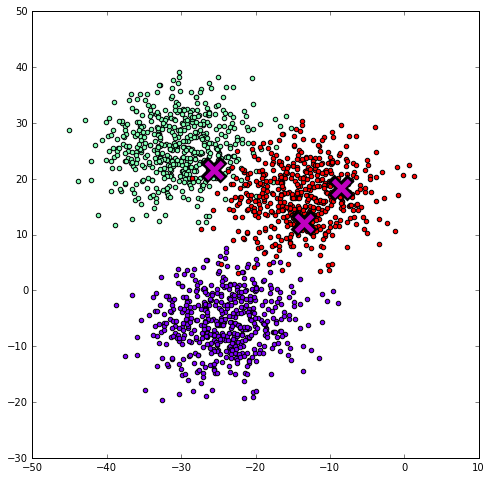

In [6]:
n_features = 2
n_clusters = 3
n_samples_per_cluster = 500
seed = 700
embiggen_factor= 70

np.random.seed(seed)

centroids, samples = create_samples(n_clusters, n_samples_per_cluster, n_features, embiggen_factor, seed)
initial_centroids = choose_random_centroids(samples, n_clusters)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sample_values = sess.run(samples)
    updated_centroid_values = sess.run(initial_centroids)
    
plot_clusters(sample_values, updated_centroid_values, n_samples_per_cluster)   

## Updating Centroids

In [7]:
def assign_to_nearest(samples, centroids):
    expanded_vectors = tf.expand_dims(samples, 0)
    expanded_centroids = tf.expand_dims(centroids, 1)
    distances = tf.reduce_sum(tf.square(tf.sub(expanded_vectors, expanded_centroids)), 2)
    mins = tf.argmin(distances, 0)
    
    nearest_indices = mins
    return nearest_indices

In [8]:
def update_centroids(samples, nearest_indices, n_clusters):
    nearest_indices = tf.to_int32(nearest_indices)
    partitions = tf.dynamic_partition(samples, nearest_indices, n_clusters)
    new_centroids = tf.concat(0, [tf.expand_dims(tf.reduce_mean(partition, 0), 0) for partition in partitions])
    return new_centroids

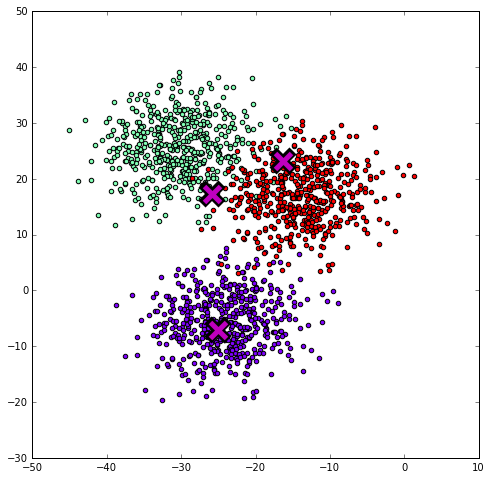

In [9]:
import time
from IPython import display

n_features = 2
n_clusters = 3
n_samples_per_cluster = 500
seed = 700
embiggen_factor= 70

np.random.seed(seed)

centroids, samples = create_samples(n_clusters, n_samples_per_cluster, n_features, embiggen_factor, seed)
initial_centroids = choose_random_centroids(samples, n_clusters)
nearest_indices = assign_to_nearest(samples, initial_centroids)
updated_centroids = update_centroids(samples, nearest_indices, n_clusters)

with tf.Session() as sess:
    samples = create_samples(n_clusters, n_samples_per_cluster, n_features, embiggen_factor, seed)
    updated_centroid_values = sess.run(updated_centroids)
    
plot_clusters(sample_values, updated_centroid_values, n_samples_per_cluster)

## Exercise

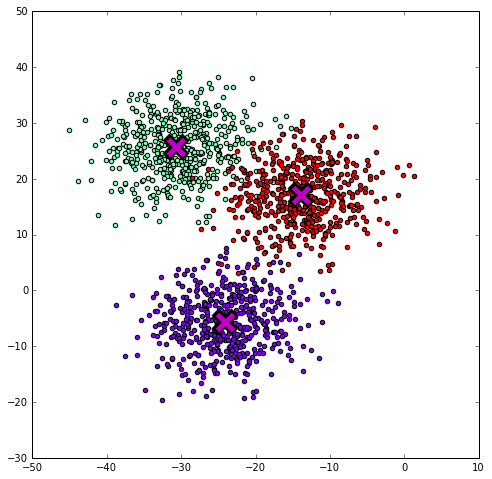

In [45]:
import time
from IPython import display

def choose_random_centroids(samples, n_clusters):
    n_samples = tf.shape(samples)[0]
    random_indices = tf.random_shuffle(tf.range(0, n_samples))
    begin=[0]
    size = [n_clusters]
    centroid_indices = tf.slice(random_indices, begin, size)
    initial_centroids = tf.gather(samples, centroid_indices)
    
    return initial_centroids


n_features = 2
n_clusters = 3
n_samples_per_cluster = 500
seed = 700
embiggen_factor= 70

np.random.seed(seed)

centroids, samples = create_samples(n_clusters, n_samples_per_cluster, n_features, embiggen_factor, seed)

sess = tf.Session()
sample_values = sess.run(samples)

sample_values_tf = tf.constant(sample_values)
initial_centroids = choose_random_centroids(sample_values_tf, n_clusters)
centroids_values = tf.Variable(initial_centroids)

sess.run(tf.global_variables_initializer())

nearest_indices = assign_to_nearest(sample_values, centroids_values)
new_centroids_values = update_centroids(sample_values_tf, nearest_indices, n_clusters)
update = tf.assign(centroids_values, new_centroids_values)

for i in range(10):
    centroids_values_rst = sess.run(update)
    plot_clusters(sample_values,centroids_values_rst, n_samples_per_cluster)
    display.clear_output(wait=True)
    time.sleep(1)